In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [23]:
def preprocess(df: pd.DataFrame):
    """
    Enlève toutes les colonnes sauf la date, le débit horaire et le taux d'occupation
    et formatte les dates en type datetime
    pour ensuite en extraire année, jour, mois, heure et jour de la semaine
    Réordonne les données temporellement
    """
    temp = df[["Débit horaire", "Taux d'occupation"]].copy()
    temp["Date et heure de comptage"] = pd.to_datetime(df["Date et heure de comptage"], utc=True)
    temp = temp.sort_values("Date et heure de comptage")
    temp = temp.set_index("Date et heure de comptage")
    temp["datetime"] = temp.index
    temp["year"] = temp.index.year
    temp["month"] = temp.index.month
    temp["day"] = temp.index.day
    temp["hour"] = temp.index.hour
    # Récupère les jours de la semaine : 0 -> lundi, 6 -> dimanche
    temp["dayofweek"] = temp.index.dayofweek
    temp[["Débit horaire", "Taux d'occupation"]] = temp[["Débit horaire", "Taux d'occupation"]].interpolate("time")
    return temp

def get_covid_data(path="data/OxCGRT_latest.csv"):
    """
    Récupère les données covid pour la France récoltées par Oxford
    Ces données apporte des informations sur les restrictions gouvernementales
    Une explication des données covid est disponible dans le fichier data/doc-oxford.pdf
    """
    oxford_data = pd.read_csv(path, sep=";")
    france_data = oxford_data[oxford_data["CountryName"] == "France"]
    france_data = france_data[['Date', 'C1_School closing',
        'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements',
        'C7_Restrictions on internal movement', 'StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay',]]
    france_data["Date"] = pd.to_datetime(france_data["Date"].astype(str).apply(lambda date: f"{date[:4]}-{date[4:6]}-{date[6:]}"))
    france_data.index = france_data["Date"]
    france_data = france_data.interpolate("time")
    france_data = france_data.reset_index(drop=True)
    return france_data

def add_covid_data(df: pd.DataFrame, covid_data_france:pd.DataFrame):
    """
    df est la base de données à laquelle on veut ajouter les données covid
    df doit contenir une colonne datetime de type datetime
    !Attention! : pour éviter les problèmes lors de la jointure la colonne index de la 
    base de données est supprimée
    """
    # Préparation de la base de données pour le join
    temp = df.copy()
    temp["Date"] = pd.to_datetime(temp.datetime.dt.date)
    temp = temp.reset_index(drop=True)

    # Join
    # Comme les données manquantes sont uniquement celles avant 2020
    # la valeurs des indicateurs associées peut être 0
    joined = pd.merge(temp, covid_data_france, how="left", on="Date").fillna(0)
    return joined

In [24]:
france_data = get_covid_data("../data/OxCGRT_latest.csv")

<AxesSubplot:xlabel='Date'>

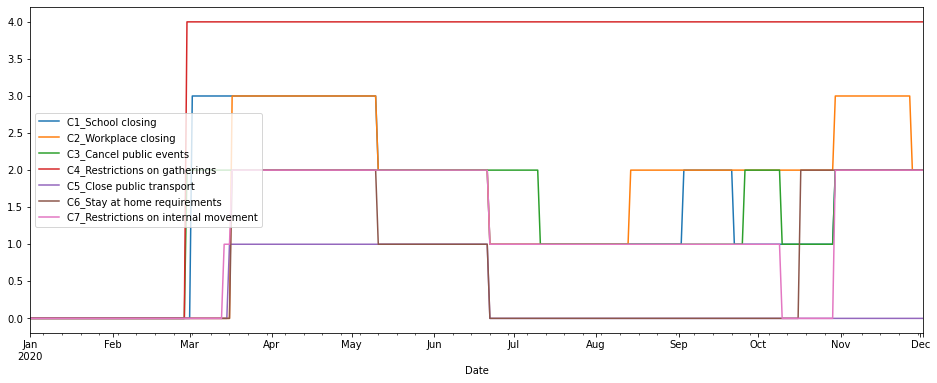

In [59]:
fig, ax = plt.subplots(figsize=(16,6))
france_data.drop(columns=['StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay']).plot(x="Date", ax = ax)

In [75]:
def interpolate_covid_data(covid_data: pd.DataFrame, num_interpolation_day=1):
    """
    Pour pouvoir utiliser les données du Covid sur de nouvelles dates,
    il faut interpoler ces valeurs, l'interpolation peut se faire en 
    gardant les dernières valeurs apparues dans les données, ou en 
    ajoutant les données transmises par le gouvernement à la main.
    Pour l'instant l'interpolation naive est utilisée.
    """
    interpolation = covid_data.copy()
    max_date = interpolation["Date"].max()
    to_add = pd.DataFrame({
        "Date": pd.date_range(max_date+timedelta(days=1), max_date+timedelta(days=num_interpolation_day))
    })
    interpolation = interpolation.append(to_add, ignore_index=True)
    interpolation = interpolation.set_index("Date")
    interpolation = interpolation.interpolate("time")
    interpolation = interpolation.reset_index()
    return interpolation

<AxesSubplot:xlabel='Date'>

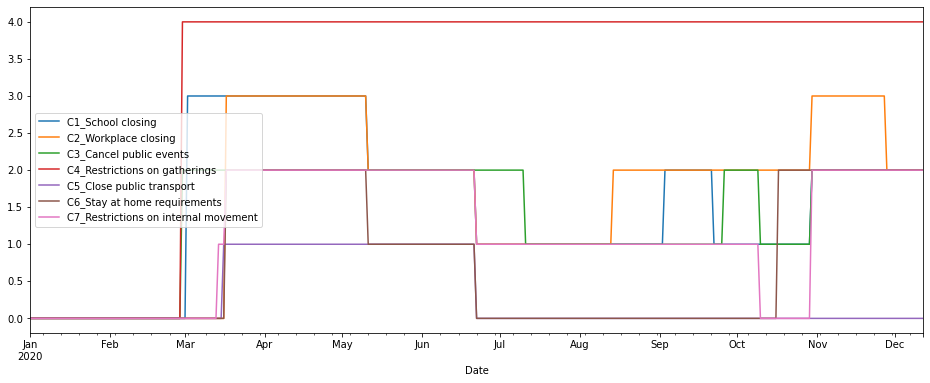

In [78]:
france_interpolation = interpolate_covid_data(france_data, 10)

fig, ax = plt.subplots(figsize=(16,6))
france_interpolation.drop(columns=['StringencyLegacyIndexForDisplay',
        'ContainmentHealthIndexForDisplay']).plot(x="Date", ax = ax)

In [29]:
raw_convention = pd.read_csv('../data/comptages-routiers-permanents-convention.csv', sep=";")
data_convention = preprocess(raw_convention)
raw_champs = pd.read_csv('../data/comptages-routiers-permanents-champs.csv', sep=";")
data_champs = preprocess(raw_champs)
raw_peres = pd.read_csv('../data/comptages-routiers-permanents-peres.csv', sep=";")
data_peres = preprocess(raw_peres)
data_convention.head()

,Débit horaire,Taux d'occupation,datetime,year,month,day,hour,dayofweek
Date et heure de comptage,,,,,,,,
2019-11-01 03:00:00+00:00,323.0,1.67722,2019-11-01 03:00:00+00:00,2019,11,1,3,4
2019-11-01 04:00:00+00:00,272.0,1.41056,2019-11-01 04:00:00+00:00,2019,11,1,4,4
2019-11-01 05:00:00+00:00,240.0,1.35667,2019-11-01 05:00:00+00:00,2019,11,1,5,4
2019-11-01 06:00:00+00:00,216.0,1.14056,2019-11-01 06:00:00+00:00,2019,11,1,6,4
2019-11-01 07:00:00+00:00,260.0,1.85722,2019-11-01 07:00:00+00:00,2019,11,1,7,4


In [39]:
joined = add_covid_data(data_peres, france_data)
joined.head()

,Débit horaire,Taux d'occupation,datetime,year,month,day,hour,dayofweek,Date,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,StringencyLegacyIndexForDisplay,ContainmentHealthIndexForDisplay
0,259.0,3.00611,2019-11-01 03:00:00+00:00,2019,11,1,3,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,197.0,2.50778,2019-11-01 04:00:00+00:00,2019,11,1,4,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,163.0,2.05111,2019-11-01 05:00:00+00:00,2019,11,1,5,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,170.0,2.08944,2019-11-01 06:00:00+00:00,2019,11,1,6,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,225.0,2.91500,2019-11-01 07:00:00+00:00,2019,11,1,7,4,2019-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9430 entries, 0 to 9429
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   Débit horaire                         9430 non-null   float64            
 1   Taux d'occupation                     9430 non-null   float64            
 2   datetime                              9430 non-null   datetime64[ns, UTC]
 3   year                                  9430 non-null   int64              
 4   month                                 9430 non-null   int64              
 5   day                                   9430 non-null   int64              
 6   hour                                  9430 non-null   int64              
 7   dayofweek                             9430 non-null   int64              
 8   Date                                  9430 non-null   datetime64[ns]     
 9   C1_School closing  

In [41]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [42]:
# retrieve occupation 
X = joined.drop(columns=["Débit horaire", "Taux d'occupation", "datetime", "Date"])
X_train, X_test, debit_train, debit_test, occupation_train, occupation_test = train_test_split(X, joined["Débit horaire"], joined["Taux d'occupation"])

In [83]:
def xgb_shap(data):
    joined = add_covid_data(data, france_data)
    X = joined.drop(columns=["Débit horaire", "Taux d'occupation", "datetime", "Date"])
    X_train, X_test, debit_train, debit_test, occupation_train, occupation_test = train_test_split(X, joined["Débit horaire"], joined["Taux d'occupation"])
    xg_debit = xgb.XGBRegressor()
    xg_debit.fit(X_train, debit_train)
    xg_occupation = xgb.XGBRegressor()
    xg_occupation.fit(X_train, occupation_train)
    pred_debit = xg_debit.predict(X_test)
    pred_occupation = xg_occupation.predict(X_test)
    print("Score R2 debit:", r2_score(pred_debit, debit_test))
    print("RMSE debit:", mean_squared_error(pred_debit, debit_test, squared=False))
    print("MAE debit:", mean_absolute_error(pred_debit, debit_test))
    print("Score R2 occupation:", r2_score(pred_occupation, occupation_test))
    print("RMSE occupation:", mean_squared_error(pred_occupation, occupation_test, squared=False))
    print("MAE occupation:", mean_absolute_error(pred_occupation, occupation_test))
    exp_debit = shap.TreeExplainer(xg_debit)
    shap_debit = exp_debit.shap_values(X_test)
    exp_occupation = shap.TreeExplainer(xg_occupation)
    shap_occupation = exp_occupation.shap_values(X_test)
    shap.summary_plot(shap_debit, feature_names=X.columns)
    shap.summary_plot(shap_occupation, feature_names=X.columns)
    return xg_debit, xg_occupation

Score R2 debit: 0.96594092964755
RMSE debit: 59.39421032527253
MAE debit: 41.926864289680836
Score R2 occupation: 0.7934642307625489
RMSE occupation: 3.8408981205311004
MAE occupation: 1.868374090233824


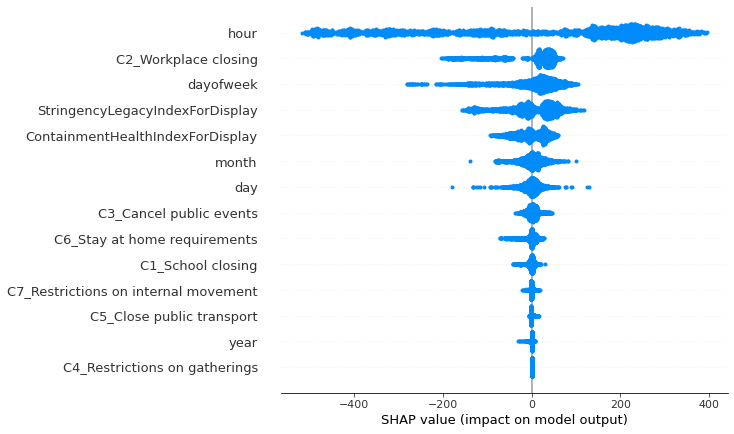

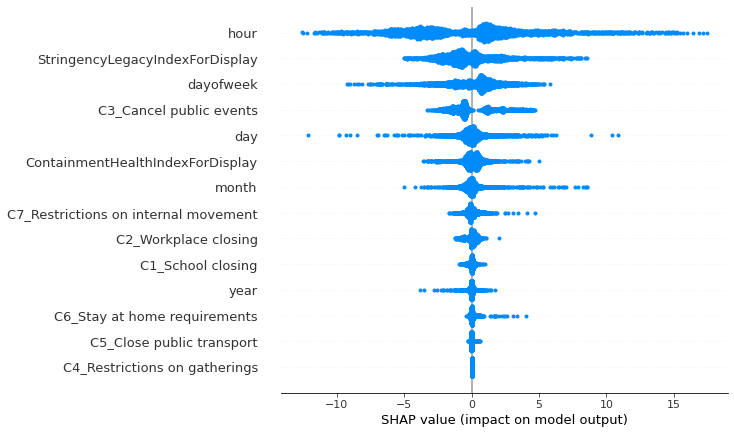

In [84]:
xg_convention_debit, xg_convention_occupation = xgb_shap(data_convention)

Score R2 debit: 0.9559662358535795
RMSE debit: 85.08910639381223
MAE debit: 57.12292806905321
Score R2 occupation: 0.8448335277056637
RMSE occupation: 4.259320701923668
MAE occupation: 2.3684803166819326


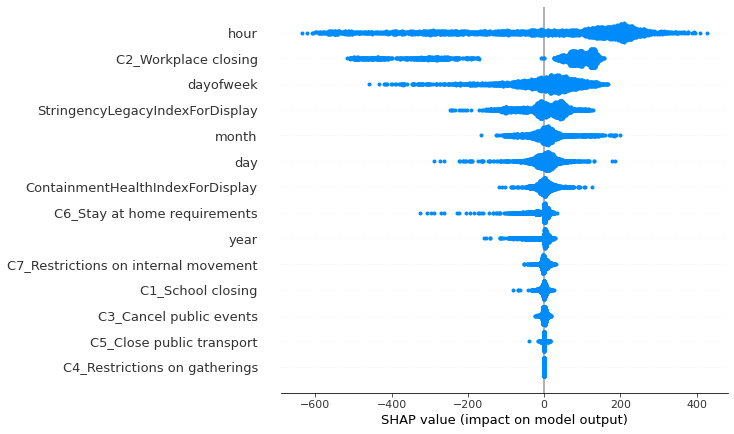

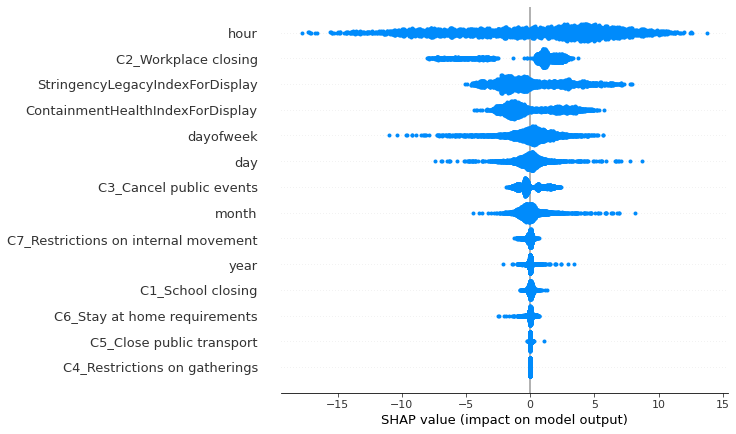

In [51]:
xg_champs_debit, xg_champs_occupation = xgb_shap(data_champs)

Score R2 debit: 0.9766948846843173
RMSE debit: 41.84885155763718
MAE debit: 29.87806578050875
Score R2 occupation: 0.8713400552086779
RMSE occupation: 1.7557122602198496
MAE occupation: 0.9383501775691344


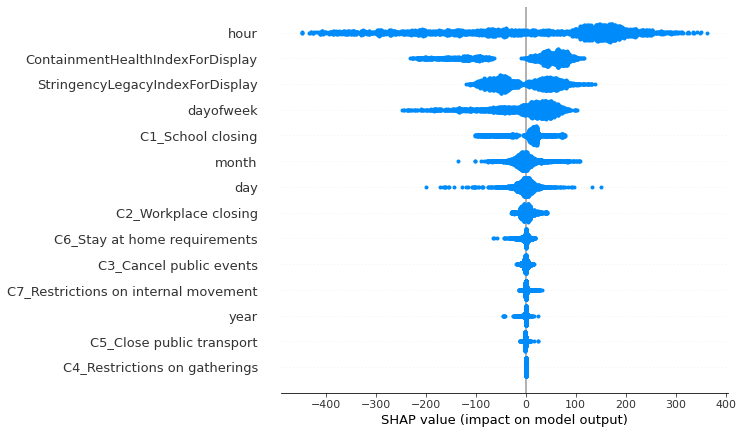

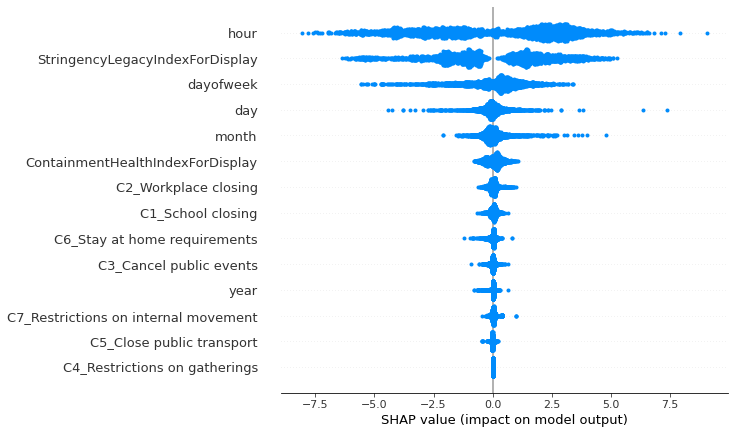

In [52]:
xg_peres_debit, xg_peres_occupation = xgb_shap(data_peres)